In [1]:
from opendr.perception.object_detection_2d.nanodet.algorithm.nanodet.data.transform.warp import ShapeTransform
from opendr.engine.target import BoundingBox
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
import cv2
import pandas as pd
from PIL import Image

random.seed("123")

# Functions

In [2]:
def write_to_xml(image_name, bboxes, dabase_name, save_folder, xml_template='pascal_voc_template.xml'):
    # read xml file
    tree = ET.parse(xml_template)
    root = tree.getroot()

    # modify
    folder = root.find('folder')
    folder.text = 'Annotations'

    fname = root.find('filename')
    fname.text = image_name

    src = root.find('source')
    database = src.find('database')
    database.text = dabase_name

    h, w = bboxes[0][5]
    d = 3
    size = root.find('size')
    width = size.find('width')
    width.text = str(w)
    height = size.find('height')
    height.text = str(h)
    depth = size.find('depth')
    depth.text = str(d)

    for box in bboxes:
        # append object
        obj = ET.SubElement(root, 'object')

        name = ET.SubElement(obj, 'name')
        name.text = box[0]

        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = str(0)

        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = str(0)

        bndbox = ET.SubElement(obj, 'bndbox')

        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(box[1]))

        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(box[2]))

        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(box[3]))

        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(box[4]))

    # save .xml to anno_path
    anno_path = os.path.join(save_folder, "annotations", image_name.split('.')[0] + '.xml')
    tree.write(anno_path)

def calculate_iou(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    x1_, y1_, x2_, y2_ = bbox2
    # Calculate the intersection coordinates
    xi1, yi1, xi2, yi2 = max(x1, x1_), max(y1, y1_), min(x2, x2_), min(y2, y2_)
    # Calculate the area of the intersection
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    # Calculate the area of both bounding boxes
    bbox1_area = (x2 - x1) * (y2 - y1)
    bbox2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the union area
    union_area = bbox1_area + bbox2_area - intersection_area
    # Calculate the IoU
    iou = intersection_area / union_area
    return iou


def is_valid_bbox(bboxes_list, bbox, th):
    for i, box in enumerate(bboxes_list):
        iou = calculate_iou(bbox, box)
        if iou>th:
            return False
    return True

def random_crop(image, crop_size_ratio=0):
    width, height, ch = image.shape
    if isinstance(crop_size_ratio, tuple):
        crop_size_ratio_x = crop_size_ratio[0]
        crop_size_ratio_y = crop_size_ratio[1]
    else:
        crop_size_ratio_x = crop_size_ratio
        crop_size_ratio_y = crop_size_ratio
    if crop_size_ratio_x > 1 or crop_size_ratio_y > 1:
        raise ValueError("Crop size ratio should be smaller than 1")
    after_crop_pixels_y = random.randint(height - int(width*crop_size_ratio_y), height)
    after_crop_pixels_x = random.randint(width - int(width*crop_size_ratio_x), width)
    x = int(width/2)
    y = int(height/2)
    left = int(x - after_crop_pixels_x/2)
    right = int(left + after_crop_pixels_x)
    top = int(y - after_crop_pixels_y/2)
    bottom = int(top + after_crop_pixels_y)
    return image[left:right, top:bottom, :]

def random_stretch(image, stretch_ratio_th=(1, 1)):
    if isinstance(stretch_ratio_th[0], tuple):
        resize_ratio_th_x_neg = stretch_ratio_th[0][0]
        resize_ratio_th_x_pos = stretch_ratio_th[0][1]
        resize_ratio_th_y_neg = stretch_ratio_th[1][0]
        resize_ratio_th_y_pos = stretch_ratio_th[1][1]
    else:
        resize_ratio_th_x_neg = stretch_ratio_th[0]
        resize_ratio_th_x_pos = stretch_ratio_th[0]
        resize_ratio_th_y_neg = stretch_ratio_th[1]
        resize_ratio_th_y_pos = stretch_ratio_th[1]
    width, height, ch = image.shape
    stretch_ration_x = random.uniform(resize_ratio_th_x_neg, resize_ratio_th_x_pos)
    stretch_ration_y = random.uniform(resize_ratio_th_y_neg, resize_ratio_th_y_pos)
    new_dimensions = (int(height*stretch_ration_y), int(width*stretch_ration_x)) #C format
    return cv2.resize(image, dsize=new_dimensions, interpolation=cv2.INTER_LINEAR)

def resize(image, resize_ratio=1):
    width, height, ch = image.shape
    new_dimensions = (int(height*resize_ratio), int(width*resize_ratio)) #C format
    return cv2.resize(image, new_dimensions, interpolation=cv2.INTER_LINEAR)

def random_resize(image, resize_ratio_th=1):
    if isinstance(resize_ratio_th, tuple):
        resize_ratio_th_neg = resize_ratio_th[0]
        resize_ratio_th_pos = resize_ratio_th[1]
    else:
        resize_ratio_th_neg = resize_ratio_th
        resize_ratio_th_pos = resize_ratio_th
    resize_ratio = random.uniform(resize_ratio_th_neg, resize_ratio_th_pos)
    return resize(image, resize_ratio)

def random_pad(image, pad_th=0):
    pad = random.uniform(0, pad_th)
    width, height, ch = image.shape
    top = int(height*random.uniform(0, pad_th))
    bottom = int(height*random.uniform(0, pad_th))
    left = int(width*random.uniform(0, pad_th))
    right = int(width*random.uniform(0, pad_th))
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_WRAP)

def random_rotate_image(images, angle_th=0):
    if isinstance(angle_th, tuple):
        angle_th_neg = angle_th[0]
        angle_th_pos = angle_th[1]
    else:
        angle_th_neg = -angle_th
        angle_th_pos = angle_th
    # Generate a random angle between "angle_th_neg" and "angle_th_pos" degrees
    angle = random.uniform(angle_th_neg, angle_th_pos)
    new_images = []
    for image in images:
        # Calculate the dimensions needed to maintain the original size
        width, height, ch = image.shape

        cos_angle = np.abs(np.cos(np.radians(angle)))
        sin_angle = np.abs(np.sin(np.radians(angle)))
        new_w = int((height * sin_angle) + (width * cos_angle))
        new_h = int((height * cos_angle) + (width * sin_angle))

        center = (width // 2, height // 2)
        # Get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D((center[1], center[0]), angle, 1.0)
        # Update the translation part of the rotation matrix to keep the new dimensions
        rotation_matrix[0, 2] += (new_h / 2) - center[1]
        rotation_matrix[1, 2] += (new_w / 2) - center[0]
        # print("+++++++++++++++++++++++++++++++++++++++++")
        # print(rotation_matrix)
        # print("+++++++++++++++++++++++++++++++++++++++++")
        # Rotate the image
        new_images.append(cv2.warpAffine(image, rotation_matrix, (new_h, new_w), flags=cv2.INTER_LINEAR))
    return new_images

def random_flip(image, flip_th=0):
    if isinstance(flip_th, tuple):
        flip_vert = flip_th[0]
        flip_hor = flip_th[1]
    else:
        flip_vert = flip_th
        flip_hor = flip_th
    if random.random() < flip_hor:
        image = cv2.flip(image, 1)
    if random.random() < flip_vert:
        image = cv2.flip(image, 0)
    return image

def augmentations(image, flip_th=0, scale_th=1, stretch_th=(1, 1), crop_th=0, pad_th=0, angle_th=0):
    image = random_flip(image, flip_th)
    image = random_resize(image, scale_th)
    image = random_stretch(image, stretch_th)
    image = random_crop(image, crop_th)
    image_pad = random_pad(image, pad_th)
    images = random_rotate_image([image_pad, image], angle_th)
    return images[0], images[1]

def update_mask(mask, new_position, mask_pixel_blur, new_image_shape, image_mask=None):
    if image_mask is not None:
        mask[image_mask[:,:,0]==0] = 0
        image_mask[image_mask>20] = 0
        image_mask[image_mask>0] = 1

        mask[image_mask[:,:,0]>0] = 255
        return mask
    plus_mask_boundaries_top_left = (new_position[0]-mask_pixel_blur if new_position[0]-mask_pixel_blur>0 else 0,
                                     new_position[0]+new_image_shape[0]+mask_pixel_blur
                                     if new_position[0]+new_image_shape[0]+mask_pixel_blur<new_image.shape[0] else new_image.shape[0])
    plus_mask_boundaries_bottom_right = (new_position[1]-mask_pixel_blur if new_position[1]-mask_pixel_blur>0 else 0,
                                         new_position[1]+new_image_shape[1]+mask_pixel_blur
                                         if new_position[1]+new_image_shape[1]+mask_pixel_blur<new_image.shape[1] else new_image.shape[1])

    mask[plus_mask_boundaries_top_left[0]:plus_mask_boundaries_top_left[1], plus_mask_boundaries_bottom_right[0]:plus_mask_boundaries_bottom_right[1], :] = 255
    mask[new_position[0]+mask_pixel_blur:new_position[0]+new_image_shape[0]-mask_pixel_blur, new_position[1]+mask_pixel_blur:new_position[1]+new_image_shape[1]-mask_pixel_blur, :] = 0
    return mask

def detect_only_image(image):
    new_mask = cv2.inRange(image, 0, 1)
    new_mask[new_mask>0] = 1
    prewitt_x = np.array([[-3, 0, 1],
                          [-3, 0, 1],
                          [-3, 0, 1]])
    prewitt_y = np.array([[-3, -3, -3],
                          [ 0,  0,  0],
                          [ 1,  1,  1]])
    prewitt_xy = np.array([[-1, -1,  0],
                           [-1,  0,  3],
                           [ 0,  3,  3]])
    prewitt_yx = np.array([[0, -3, -3],
                           [1,  0, -3],
                           [1,  1,  0]])
    # Apply Prewitt kernels
    edges_x = cv2.filter2D(new_mask, -1, prewitt_x)
    edges_y = cv2.filter2D(new_mask, -1, prewitt_y)
    edges_xy = cv2.filter2D(new_mask, -1, prewitt_xy)
    edges_yx = cv2.filter2D(new_mask, -1, prewitt_yx)
    edges_x2 = cv2.filter2D(new_mask, -1, -prewitt_x)
    edges_y2 = cv2.filter2D(new_mask, -1, -prewitt_y)
    edges_xy2 = cv2.filter2D(new_mask, -1, -prewitt_xy)
    edges_yx2 = cv2.filter2D(new_mask, -1, -prewitt_yx)
    # Combine the results
    edges = edges_x+edges_y+edges_xy+edges_yx+edges_xy2+edges_yx2+edges_x2+edges_y2
    edges = np.tile(edges[:, :, np.newaxis], (1, 1, 3))
    # edges[edges>0] = 1
    return edges

def read_annotation_file(filename, class_default="weed"):
    root = ET.parse(filename).getroot()
    bounding_boxes = []
    for obj in root.iter('object'):
        cls_name = class_default
        if cls_name is None:
            cls_name = obj.find('name').text.strip().lower()
        xml_box = obj.find('bndbox')
        xmin = (float(xml_box.find('xmin').text))
        ymin = (float(xml_box.find('ymin').text))
        xmax = (float(xml_box.find('xmax').text))
        ymax = (float(xml_box.find('ymax').text))
        bounding_box = BoundingBox(name=cls_name,
                                   left=float(xmin), top=float(ymin),
                                   width=float(xmax),
                                   height=float(ymax))
        bounding_boxes.append(bounding_box.coco())
    return bounding_boxes

# Create simple dataset (white noice background with one random positive and else negatives in a 96X96 image)

In [5]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [6]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [7]:
# create an empty image with the desired shape (32, 32, 3)
image_size = (96, 96, 3)
background = np.zeros(image_size, dtype=np.uint8)

# # fill the image with random RGB values
# image[:, :, 0] = np.random.randint(0, 256, (32, 32)) # fill the Red channel with random values
# image[:, :, 1] = np.random.randint(0, 256, (32, 32)) # fill the Green channel with random values
# image[:, :, 2] = np.random.randint(0, 256, (32, 32)) # fill the Blue channel with random values

# add white noise to the image
noise = np.random.normal(0, 60, image_size)
background = background + noise

# clip the values to make sure they stay within the valid range (0-255)
background = np.clip(background, 0, 255).astype(np.uint8)

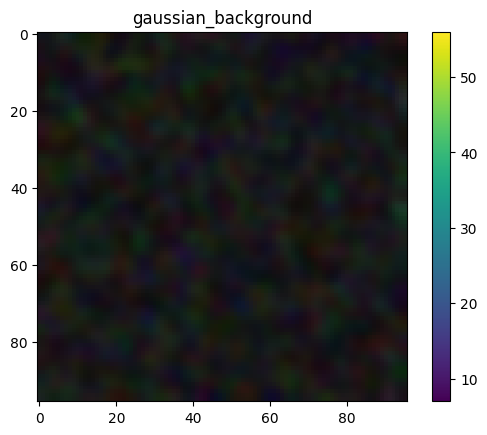

In [8]:
gaussian_background = cv2.GaussianBlur(background, (9, 9), 0)
plt.imshow(gaussian_background)
plt.title(f'gaussian_background')
plt.colorbar()
plt.show()

dataset_name: Football
bboxes :[['player', 1260, 863, 1307, 910, (1088, 1920)], ['player', 1375, 333, 1418, 376, (1088, 1920)], ['player', 1682, 682, 1718, 718, (1088, 1920)], ['player', 766, 491, 817, 542, (1088, 1920)], ['player', 210, 95, 281, 166, (1088, 1920)], ['player', 1435, 11, 1502, 80, (1088, 1920)], ['player', 1692, 422, 1765, 495, (1088, 1920)], ['player', 1271, 645, 1345, 721, (1088, 1920)], ['player', 984, 781, 1027, 827, (1088, 1920)], ['player', 145, 987, 188, 1029, (1088, 1920)], ['player', 1395, 965, 1446, 1012, (1088, 1920)], ['player', 1333, 445, 1387, 499, (1088, 1920)], ['player', 368, 511, 425, 567, (1088, 1920)], ['player', 472, 893, 538, 956, (1088, 1920)], ['player', 1248, 957, 1290, 1000, (1088, 1920)], ['player', 1538, 800, 1587, 851, (1088, 1920)], ['player', 562, 191, 617, 246, (1088, 1920)], ['player', 1616, 511, 1680, 576, (1088, 1920)], ['player', 1052, 443, 1115, 508, (1088, 1920)], ['player', 20, 576, 85, 641, (1088, 1920)], ['player', 234, 716, 274,

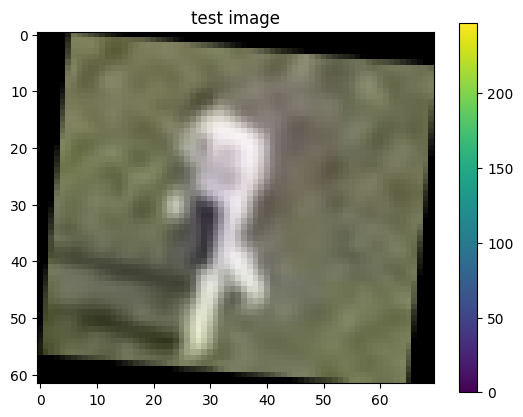

In [11]:
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

image = 0
mask = np.zeros_like(new_image)
for width in range(number_of_negs_width):
    for height in range(number_of_negs_height):
        neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
        neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

        starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
        neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
        neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
        mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
        new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

bboxes = []
bbox_padded = []
bboxes_list_padded = []
new_pos_image=np.zeros_like(new_image)
for pos_img in range(number_of_pos_img):
    pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
    pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
    temp_pos_image = np.zeros_like(new_pos_image)
    # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
    #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
    # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
    #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
    pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,2.0), stretch_th=((0.9, 1.1), (0.9, 1.1)),
                                             pad_th=0.3, crop_th=(0.0, 0.0), angle_th=90)
    position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
    bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # find correct bbox to not overlap
    while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # save actual not padded bbox
    bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
    # save bbox for future overlap
    bboxes_list_padded.append(bbox_padded)
    # patch image
    temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
    pos_image_mask = detect_only_image(temp_pos_image)
    new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
    # save bbox for annotation function
    bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

    # border image mask to blue for seemingly be patch with the background
    # easier to make update_mask if is in top-left format and not center
    position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
    mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)

new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
new_image[mask>0]= blurr_image[mask>0]

print(f"dataset_name: {dataset_name}")
print(f"bboxes :{bboxes}")

plt.imshow(pos_image)
plt.title(f'test image')
plt.colorbar()
plt.show()

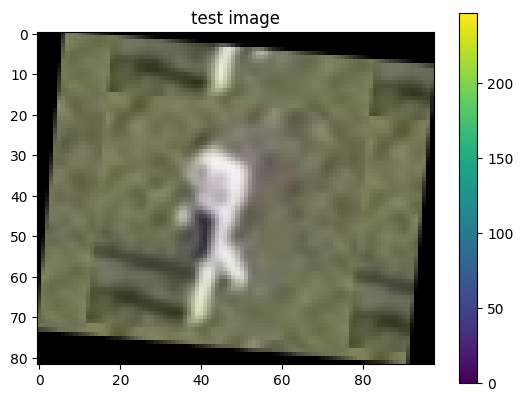

In [20]:
plt.imshow(pos_image_pad)
plt.title(f'test image')
plt.colorbar()
plt.show()

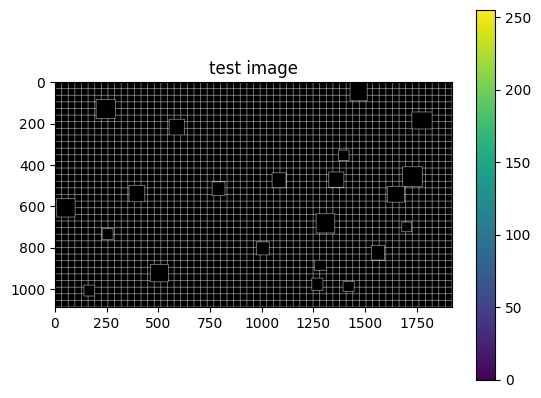

In [21]:
plt.imshow(mask)
plt.title(f'test image')
plt.colorbar()
plt.show()

In [122]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [126]:
name_prefix = "NEW"
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

data_unique_name = 'rand_neg_padded_augmented_size_0.9-2.0'
save_folder_name = f'{base_dataset_path}/{int(96*size_of_new_image[1])}x{int(96*size_of_new_image[0])}_{number_of_pos_img}pos_{number_of_negs_width*number_of_negs_height}neg'
save_folder = f'{save_folder_name}{data_unique_name}/{split}'
save_folder_eval = f'{save_folder_name}{data_unique_name}/eval'
if not os.path.exists(save_folder):
    os.makedirs(f"{save_folder}/images")
    os.makedirs(f"{save_folder}/annotations")
if split == "test":
    eval_ratio = 0/10
else:
    eval_ratio = 1/10
    if not os.path.exists(save_folder_eval):
        os.makedirs(f"{save_folder_eval}/images")
        os.makedirs(f"{save_folder_eval}/annotations")

for image in range(0, images):
    new_image = background.copy()
    new_image = random_stretch(new_image, size_of_new_image)
    mask = np.zeros_like(new_image)
    for width in range(number_of_negs_width):
        for height in range(number_of_negs_height):
            neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
            neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

            # starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
            starting_pot = (random.randint(neg_image.shape[0]//2,image_size[0]-int((neg_image.shape[0]/2)+0.6)), random.randint(neg_image.shape[1]//2,image_size[1]-int((neg_image.shape[1]/2)+0.6)))
            neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
            neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
            mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
            new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

    bboxes = []
    bbox_padded = []
    bboxes_list_padded = []
    new_pos_image=np.zeros_like(new_image)
    for pos_img in range(number_of_pos_img):
        pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
        pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
        temp_pos_image = np.zeros_like(new_pos_image)
        # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
        #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
        # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
        #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
        pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,2.0), stretch_th=((0.9, 1.1), (0.9, 1.1)),
                                                 pad_th=0.3, crop_th=(0.0, 0.0), angle_th=10)
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

        # find correct bbox to not overlap
        loop_count = 0
        while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
            if loop_count >=20:
                break
            position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
            bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]
            loop_count += 1


        # save actual not padded bbox
        bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
        # save bbox for future overlap
        bboxes_list_padded.append(bbox_padded)
        # patch image
        temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
        pos_image_mask = detect_only_image(temp_pos_image)
        new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
        # save bbox for annotation function
        bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

        # border image mask to blue for seemingly be patch with the background
        # easier to make update_mask if is in top-left format and not center
        position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
        # mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)
        mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape, image_mask=pos_image_mask)

    new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
    blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
    new_image[mask>0]= blurr_image[mask>0]

    image_name = f'{name_prefix}{image:05}.bmp'
    final_folder = save_folder_eval if (random.uniform(0, 1) < eval_ratio) else save_folder
    plt.imsave(f"{final_folder}/images/{image_name}", new_image)
    write_to_xml(image_name, bboxes, dataset_name, f"{final_folder}", xml_template='pascal_voc_template.xml')

In [6]:
for subdir, dirs, files in os.walk(dataset_path):
    print(files)
    print(subdir)
    print(dirs)
    print("========================================")

['7_9419c072274afb30ab44.jpg', '13_51f8688e522ed9f664d2.jpg', '2_224bf3da30cffd55241e.jpg', '14_0e0059614fff6c4a110f.jpg', '11_27ede69bcaf1d276324a.jpg', '9_9767617e27274f2c7590.jpg', '6_069f0411630016b317b2.jpg', '3_276081efd5d158cbaeeb.jpg', '5_b7619122f921c125d11a.jpg', '5_13d5127e2cd3adbe394d.jpg', '8_c7a78029555bd64555ea.jpg', '3_e08b05cb5d7c2f76832c.jpg', '4_b1ef503aaea27790fdd7.jpg', '5_c2f024963bb0c155ed7c.jpg', '6_cb75290798f9ea9a2cb9.jpg', '13_b0c23de1b3273eea8a4b.jpg', '13_64f90c3f04b4c4d9553e.jpg', '0_3abc45bb159f74e94cfe.jpg', '2_5754eb8324e78882df9d.jpg', '0_ce02c864ef6b8df2f9f8.jpg', '5_cce4af327a3fdccc17e7.jpg', '9_3ed837c04c1b5c9737c6.jpg', '0_de3123458fd9efccc64e.jpg', '0_d2b789e4aee3815bb48c.jpg', '10_832334e5a4041d66cab0.jpg', '0_5e404113639ca62115d6.jpg', '15_892f8aecaaf1b9246b5d.jpg', '0_c694b96f4fbae4e5cdc6.jpg', '0_f873f0247303a89f64e9.jpg', '2_e4249c7dc4379e53fb83.jpg', '10_cad6071be831c5e7b697.jpg', '0_3e4ac7ee9f002fb1eceb.jpg', '3_d89a57bf9c6e7901cd55.jpg', '

In [7]:
# Define the path to the dataset
base_dataset_path = "/media/manos/hdd/allea_datasets/weedDataset/cropped_images"
dataset_path = f'{base_dataset_path}/train/images'

# Initialize variables to store the sum of means and standard deviations for each channel
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

# Iterate over all images in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    if subdir == dataset_path:
        for file in files:
            # Load the image
            image = Image.open(os.path.join(subdir, file))

            # Convert the image to a numpy array
            image_np = np.array(image)

            # Calculate the mean and standard deviation for each channel
            mean_sum += np.mean(image_np, axis=(0, 1))
            std_sum += np.std(image_np, axis=(0, 1))

            # Increment the number of images
            num_images += 1


# Calculate the mean and standard deviation for each channel for the entire dataset
mean = mean_sum / num_images
std = std_sum / num_images

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [ 98.45438741 104.10689567  98.17277835]
Std: [34.79841708 31.2228376  29.66469302]


##Crop & Weed

In [12]:
dataset_main_path = "/media/manos/hdd/allea_datasets/weedDataset"
dataset_new_name = "4k"

In [13]:
augm_dic = {
    "keep_ratio": False,
    "divisible": 0,
    "perspective": 0.0,
    "scale": (1, 1),
    "stretch": ((1, 1), (1, 1)),
    "rotation": 0.0,
    "shear": 0.0,
    "translate": 0.0,
    "flip": 0.0,
    "jitter_box": 0.0,
    "hard_pos": 0.0,
    "hard_pos_ratio": 0.0,
}

In [15]:
temp_img = cv2.imread(f"{dataset_main_path}/train/images/0ab7243432c893122512.jpg")
height, width = temp_img.shape[0], temp_img.shape[1]
target_height = 1088 * 2
target_width = 1920 * 2
dst_shape = (target_width, target_height)
shapeTransformer = ShapeTransform(**augm_dic)

height: 2054
width: 2456


In [ ]:
splits = ["train", "val", "test"]
for split in splits:
    dataset_load_path = f"{dataset_main_path}/{split}/images"
    dataset_save_path = f"{dataset_main_path}/{dataset_new_name}/{split}/"
    if not os.path.isdir(dataset_save_path):
        os.makedirs(f"{dataset_save_path}/images")
        os.makedirs(f"{dataset_save_path}/annotations")
    # Run the dataset
    for subdir, dirs, files in os.walk(dataset_load_path):
        for file in files:
            img = cv2.imread(f"{dataset_load_path}/{file}")
            annotation_file = f"{dataset_main_path}/{split}/annotations/{file[:-4]}.xml"
            bboxes = read_annotation_file(annotation_file)
            metadata = {"img": img, "gt_bboxes": [], "gt_labels": [], "gt_areas": []}
            for bbox in bboxes:
                metadata["gt_bboxes"].append(bbox["bbox"])
                metadata["gt_labels"].append(bbox["category_id"])
            metadata["gt_bboxes"] = np.array(metadata["gt_bboxes"])
            metadata = shapeTransformer(metadata, dst_shape)
            metadata["gt_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["gt_bboxes"]]
            cv2.imwrite(f"{dataset_save_path}/images/{file}", metadata["img"])
            annotation = [[name, box[0], box[1], box[2], box[3], dst_shape] for name,box in zip(metadata["gt_labels"], metadata["gt_bboxes"])]
            write_to_xml(file, annotation, dataset_new_name, f"{dataset_save_path}", xml_template='pascal_voc_template.xml')

### Classic crop of images into targets

In [3]:
dataset_main_path = "/media/manos/hdd/allea_datasets/weedDataset"
temp_img = cv2.imread(f"{dataset_main_path}/train/images/0ab7243432c893122512.jpg")
ori_height, ori_width = temp_img.shape[0], temp_img.shape[1]

multiplier_of = 32

target_height = 416
target_width = 416
target_height = int((target_height/multiplier_of)+1)*multiplier_of
target_width = int((target_width/multiplier_of)+1)*multiplier_of

n_h = int(ori_height/target_height)+1
n_w = int(ori_width/target_width)+1
dst_shape = (target_width, target_height)

offset_height = ((ori_height - target_height)/(n_h-1)) - target_height
offset_width = ((ori_width - target_width)/(n_w-1)) - target_width

offset_height = int(offset_height)
offset_width = int(offset_width)

image_height_boarders = [((n*(target_height+offset_height)), (n*(target_height+offset_height))+target_height) for n in range(n_h)]
image_width_boarders = [((n*(target_width+offset_width)), (n*(target_width+offset_width))+target_width) for n in range(n_w)]

image_boarders = []
for h_b in image_height_boarders:
    for w_b in image_width_boarders:
        image_boarders.append((h_b, w_b))

In [4]:
print(f"original height: {ori_height}, width: {ori_width}")
print(f"offset height: {offset_height}")
print(f"offset width: {offset_width}")
print(f"boarders height: {image_height_boarders}")
print(f"boarders width: {image_width_boarders}")
print(f"full boarders: {image_boarders}\nWith length: {len(image_boarders)}")

original height: 2054, width: 2456
offset height: -46
offset width: -46
boarders height: [(0, 448), (402, 850), (804, 1252), (1206, 1654), (1608, 2056)]
boarders width: [(0, 448), (402, 850), (804, 1252), (1206, 1654), (1608, 2056), (2010, 2458)]
full boarders: [((0, 448), (0, 448)), ((0, 448), (402, 850)), ((0, 448), (804, 1252)), ((0, 448), (1206, 1654)), ((0, 448), (1608, 2056)), ((0, 448), (2010, 2458)), ((402, 850), (0, 448)), ((402, 850), (402, 850)), ((402, 850), (804, 1252)), ((402, 850), (1206, 1654)), ((402, 850), (1608, 2056)), ((402, 850), (2010, 2458)), ((804, 1252), (0, 448)), ((804, 1252), (402, 850)), ((804, 1252), (804, 1252)), ((804, 1252), (1206, 1654)), ((804, 1252), (1608, 2056)), ((804, 1252), (2010, 2458)), ((1206, 1654), (0, 448)), ((1206, 1654), (402, 850)), ((1206, 1654), (804, 1252)), ((1206, 1654), (1206, 1654)), ((1206, 1654), (1608, 2056)), ((1206, 1654), (2010, 2458)), ((1608, 2056), (0, 448)), ((1608, 2056), (402, 850)), ((1608, 2056), (804, 1252)), ((16

In [5]:
saved_name = "416_cropped_images"

splits = ["train", "val", "test"]
for split in splits:
    dataset_load_path = f"{dataset_main_path}/{split}/images"
    dataset_save_path = f"{dataset_main_path}/{saved_name}/{split}/"
    if not os.path.isdir(dataset_save_path):
        os.makedirs(f"{dataset_save_path}/images")
        os.makedirs(f"{dataset_save_path}/annotations")
    # Run the dataset
    for subdir, dirs, files in os.walk(dataset_load_path):
        for file in files:
            img = cv2.imread(f"{dataset_load_path}/{file}")
            annotation_file = f"{dataset_main_path}/{split}/annotations/{file[:-4]}.xml"
            bboxes = read_annotation_file(annotation_file, None)
            metadata = {"img": img, "gt_bboxes": [], "new_bboxes": [], "gt_labels": [], "gt_areas": [], "new_areas": []}
            for bbox in bboxes:
                metadata["gt_bboxes"].append(bbox["bbox"])
                metadata["gt_labels"].append(bbox["category_id"])
            metadata["gt_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["gt_bboxes"]]
            metadata["gt_bboxes"] = np.array(metadata["gt_bboxes"])

            for idx, image_boarder in enumerate(image_boarders):
                crop_boxes = []
                crop_label = []
                left = image_boarder[1][0]
                right = image_boarder[1][1]
                top = image_boarder[0][0]
                bottom = image_boarder[0][1]

                crop = img[top: bottom, left:right]


                # clip bboxes to crop images
                metadata["new_bboxes"] = [
                    [bbox[0].clip(left, right)+(target_width-right), bbox[1].clip(top, bottom)+(target_height-bottom),
                     bbox[2].clip(left, right)+(target_width-right), bbox[3].clip(top, bottom)+(target_height-bottom)
                     ] for bbox in metadata["gt_bboxes"]]

                metadata["new_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["new_bboxes"]]

                for new_area, gt_area, bbox, label in zip(metadata["new_areas"], metadata["gt_areas"], metadata["new_bboxes"], metadata["gt_labels"]):
                    if new_area<50:
                        continue
                    if new_area<(gt_area/5):
                        continue
                    crop_label.append(label)
                    crop_boxes.append(bbox)

                if len(crop_label) > 0:
                    cv2.imwrite(f"{dataset_save_path}/images/{idx}_{file}", crop)
                    annotation = [[name, box[0], box[1], box[2], box[3], (target_height, target_width)] for name,box in zip(crop_label, crop_boxes)]
                    write_to_xml(f"{idx}_{file}", annotation, saved_name, dataset_save_path, xml_template='pascal_voc_template.xml')

### Find Mean and STD

In [4]:
# Define the path to the dataset
dataset_path = f'/home/manos/data/weedDataset/small_annots/train/images'

# Initialize variables to store the sum of means and standard deviations for each channel
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

# Iterate over all images in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        image = Image.open(os.path.join(subdir, file))
        # Convert the image to a numpy array
        image_np = np.array(image)

        # Calculate the mean and standard deviation for each channel
        mean_sum += np.mean(image_np, axis=(0, 1))
        std_sum += np.std(image_np, axis=(0, 1))

        # Increment the number of images
        num_images += 1


# Calculate the mean and standard deviation for each channel for the entire dataset
mean = mean_sum / num_images
std = std_sum / num_images

print(f'Mean, Std: [[{math.ceil(mean[0]*100)/100}, {math.ceil(mean[1]*100)/100}, {math.ceil(mean[2]*100)/100}], [{math.ceil(std[0]*100)/100}, {math.ceil(std[1]*100)/100}, {math.ceil(std[2]*100)/100}]]')

Mean, Std: [[103.71, 108.77, 105.6], [31.51, 28.67, 27.91]]


### Analyze dataset

In [14]:
# Define the path to the dataset
dataset_path = f'/home/manos/data/weedDataset/original_dataset/train/annotations'

# Initialize dataframe
columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name"]
df = pd.DataFrame([], columns=columns)

# Iterate over all annotations in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        bboxes = read_annotation_file(os.path.join(subdir, file))
        bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file] for bbox in bboxes]

        # Convert the list into pandas
        df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)

# Calculate the mean and standard deviation of annotations
print("mean || std || max || min")
display(df.mean(numeric_only=True), df.std(numeric_only=True), df.max(numeric_only=True), df.min(numeric_only=True))

mean || std || max || min


xmin      1178.905486
ymin      1022.050568
xmax      1247.289476
ymax      1087.712723
width       68.383990
height      65.662155
area      7963.790284
dtype: float64

xmin        703.359598
ymin        589.965297
xmax        702.825525
ymax        587.565312
width        66.401561
height       62.507134
area      28745.552391
dtype: float64

xmin         2445.0
ymin         2043.0
xmax         2456.0
ymax         2054.0
width        1357.0
height       1610.0
area      2184770.0
dtype: float64

xmin       0.0
ymin       0.0
xmax      11.0
ymax       9.0
width      8.0
height     8.0
area      64.0
dtype: float64

In [29]:
# df_small = df[df["area"]<=200000]
df_small = df[df["width"]<64]
df_small = df_small[df_small["height"]<64]
df_small = df_small[df_small["area"]<=4000]

print(f"all annotations: {df.shape[0]}")
print(f"new annotations: {df_small.shape[0]}")

print("mean || std || max || min")
display(df_small.mean(numeric_only=True), df_small.std(numeric_only=True), df_small.max(numeric_only=True), df_small.min(numeric_only=True))

all annotations: 37751
new annotations: 21127
mean || std || max || min


xmin      1201.739149
ymin      1057.027406
xmax      1236.826620
ymax      1091.212572
width       35.087471
height      34.185166
area      1297.880674
dtype: float64

xmin      695.608472
ymin      580.003188
xmax      695.656515
ymax      579.560761
width      12.645451
height     12.499103
area      826.010038
dtype: float64

xmin      2445.0
ymin      2043.0
xmax      2456.0
ymax      2054.0
width       63.0
height      63.0
area      3969.0
dtype: float64

xmin       0.0
ymin       0.0
xmax      11.0
ymax       9.0
width      8.0
height     8.0
area      64.0
dtype: float64

In [ ]:
column_name = 'area'
column_data = df_small[column_name]
plt.hist(column_data, bins=10000, density=True, alpha=0.9)  # Adjust the number of bins as needed
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Standard Distribution of {}'.format(column_name))
plt.grid(True)
plt.show()

### Make dataset with cropped images that they have annot near middle.

In [3]:
new_image_w = 320
new_image_h = 320
area_th = 4000
splits = ["train", "val", "test"]
# splits = ["val"]
# cls_name = "weed"
dataset_path = f"/home/manos/data/weedDataset/"
dataset_path = f"/media/manos/hdd/allea_datasets/weedDataset/"
save_post_fix = "small_annots"
save_path = f'{dataset_path}/{save_post_fix}'
for split in splits:
    # Define the path to the dataset
    dataset_split_path = f'{dataset_path}/original_dataset/{split}'
    save_split_path = f'{save_path}/{split}'
    save_big_annot = f'{save_path}/big_annots/{split}'
    # Initialize dataframe
    columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name", "category"]
    df = pd.DataFrame([], columns=columns)
    # Iterate over all annotations in the dataset
    for subdir, dirs, files in os.walk(f"{dataset_split_path}/annotations"):
        for file in files:
            # Load the image annots
            bboxes = read_annotation_file(os.path.join(subdir, file), class_default=None)
            bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file, bbox["category_id"]] for bbox in bboxes]

            # Convert the list into pandas
            df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)
    # Find new df without big annotations
    df_small = df[df["width"]<new_image_w]
    df_small = df_small[df_small["height"]<new_image_h]
    df_small = df_small[df_small["area"]<=area_th].reset_index(drop=True)



    os.makedirs(f'{save_split_path}/images', exist_ok=True)
    os.makedirs(f'{save_split_path}/annotations', exist_ok=True)
    os.makedirs(f'{save_big_annot}/images', exist_ok=True)
    os.makedirs(f'{save_big_annot}/annotations', exist_ok=True)
    # short images and areas to run for each file
    df_small.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    # find unique files and make the dataframes for each one into a list
    names = [np.array(df_small.iloc[idx])[7] for idx in range(df_small.shape[0])]
    unique_names = set(names)
    list_of_dfs = [df_small[df_small["name"]==unique_name].reset_index(drop=True) for unique_name in unique_names]

    # run list of each file
    for file in list_of_dfs:
        # take name for save
        start_name = file.iloc[0]["name"][:-4]
        starting_image = cv2.imread(f"{dataset_split_path}/images/{start_name}.jpg")
        h, w = starting_image.shape[:2]
        count = 0
        # run while there is still annotations for the image
        image_big_annot_list = []
        while file.shape[0]>0:
            # take the biggest annotation
            init_bbox = list(np.array(file.iloc[0]))
            # randomly put annotation into the new image
            random_width = int(random.uniform(0, 1)*(new_image_w-init_bbox[4]))
            random_height = int(random.uniform(0, 1)*(new_image_h-init_bbox[5]))
            xmin = int(init_bbox[0]-random_width)
            ymin = int(init_bbox[1]-random_height)
            xmax = xmin+new_image_w
            ymax = ymin+new_image_h

            # find new image into the boundaries of original image
            if xmin < 0 :
                xmin = 0
                xmax = new_image_w
            if ymin < 0 :
                ymin = 0
                ymax = new_image_h
            if xmax > w :
                xmax = w
                xmin = w - new_image_w
            if ymax > h :
                ymax = h
                ymin = h - new_image_h

            #check that new image is always new width and height
            if (xmax-xmin) != new_image_w:
                print(f"width: {(xmax-xmin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])
            if (ymax-ymin) != new_image_h:
                print(f"height: {(ymax-ymin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])

            init_window = [xmin, ymin, xmax, ymax]
            new_image = starting_image[ymin:ymax, xmin:xmax]
            # Put it in coordinates of new window
            image_annot_list = [[init_bbox[-1], init_bbox[0] - init_window[0], init_bbox[1] - init_window[1],
                                 init_bbox[2] - init_window[0], init_bbox[3] - init_window[1], (new_image_w, new_image_h)]]
            image_big_annot_list.append([init_bbox[-1], init_bbox[0], init_bbox[1], init_bbox[2], init_bbox[3], (w, h)])
            drop_list = [0]
            # Run into all bboxes in the image
            for bbox_idx in range(1, file.shape[0]):
                class_name = list(np.array(file.iloc[bbox_idx]))[-1]
                bbox = list(np.array(file.iloc[bbox_idx]))[:4]
                old_area = list(np.array(file.iloc[bbox_idx]))[6]

                # Crop all annotations outside of window
                if (bbox[0] >= xmax) or (bbox[1] >= ymax) or (bbox[2] <= xmin) or (bbox[3] <= ymin):
                    continue
                # find annotations coordinates inside the window and the new area
                new_bbox_xmin = bbox[0] if bbox[0] >= xmin else xmin
                new_bbox_ymin = bbox[1] if bbox[1] >= ymin else ymin
                new_bbox_xmax = bbox[2] if bbox[2] <= xmax else xmax
                new_bbox_ymax = bbox[3] if bbox[3] <= ymax else ymax
                new_area = (new_bbox_ymax-new_bbox_ymin)*(new_bbox_xmax-new_bbox_xmin)
                if new_area <= 0:
                    print("find neg area")
                if new_area > 0:
                    percentage_area = new_area/old_area
                    if percentage_area > 1:
                        print(f"percentage area: {percentage_area}")
                        print(f"init_window:         {init_window}")
                        print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                        print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                        print(f"old area:            {old_area}")
                        print(f"new area:            {new_area}")
                    if percentage_area>0.5:
                        # Check is miss anything
                        if (new_bbox_ymax-ymin) <= 0:
                            print("new bbox HEIGHT is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        if (new_bbox_xmax-xmin) <= 0:
                            print("new bbox WIDTH is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        # Put it in coordinates of new window
                        new_bbox = [class_name, new_bbox_xmin-xmin, new_bbox_ymin-ymin, new_bbox_xmax-xmin, new_bbox_ymax-ymin, (new_image_w, new_image_h)]
                        new_big_bbox = [class_name, new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax, (w, h)]
                        if new_bbox[1] < 0 or new_bbox[2] < 0 or new_bbox[3] < 0 or new_bbox[4] < 0:
                            print(new_bbox)
                        drop_list.append(bbox_idx)
                        image_annot_list.append(new_bbox)
                        image_big_annot_list.append(new_big_bbox)
            file = file.drop(labels=drop_list, axis=0).reset_index(drop=True)
            # Save image-annotations
            # write_to_xml(f"{count}_{start_name}.jpg", image_annot_list, f"{save_post_fix}", f"{save_split_path}", xml_template='pascal_voc_template.xml')
            # cv2.imwrite(f"{save_split_path}/images/{count}_{start_name}.jpg", new_image)
            count += 1
        write_to_xml(f"{start_name}.jpg", image_big_annot_list, f"{save_post_fix}", f"{save_big_annot}", xml_template='pascal_voc_template.xml')

KeyboardInterrupt: 

In [7]:
new_image_w = 320
new_image_h = 320
area_th = 4000
splits = ["train", "val", "test"]
# splits = ["val"]
# cls_name = "weed"
dataset_path = f"/home/manos/data/weedDataset/"
dataset_path = f"/media/manos/hdd/allea_datasets/weedDataset/"
save_post_fix = "small_annots"
save_path = f'{dataset_path}/{save_post_fix}'
for split in splits:
    # Define the path to the dataset
    dataset_split_path = f'{dataset_path}/original_dataset/{split}'
    save_split_path = f'{save_path}/{split}'
    save_big_annot = f'{save_path}/big_annots/{split}'
    # Initialize dataframe
    columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name", "category"]
    df = pd.DataFrame([], columns=columns)
    # Iterate over all annotations in the dataset
    for subdir, dirs, files in os.walk(f"{dataset_split_path}/annotations"):
        for file in files:
            # Load the image annots
            bboxes = read_annotation_file(os.path.join(subdir, file), class_default=None)
            bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file, bbox["category_id"]] for bbox in bboxes]

            # Convert the list into pandas
            df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)
            
    df_small_annots = pd.DataFrame([], columns=columns)      
    for subdir, dirs, files in os.walk(f"{save_big_annot}/annotations"):
        for file in files:
            # Load the image annots
            small_annot_bboxes = read_annotation_file(os.path.join(subdir, file), class_default=None)
            small_annot_bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file, bbox["category_id"]] for bbox in small_annot_bboxes]

            # Convert the list into pandas
            df_small_annots = pd.concat([df_small_annots, pd.DataFrame(small_annot_bboxes, columns=columns)], axis=0)


    os.makedirs(f'{save_big_annot}/black_images', exist_ok=True)

    # short images and areas to run for each file
    df.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    df_small_annots.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    # find unique files and make the dataframes for each one into a list
    names = [np.array(df.iloc[idx])[7] for idx in range(df.shape[0])]
    unique_names = set(names)
    list_of_dfs = [df_small[df_small["name"]==unique_name].reset_index(drop=True) for unique_name in unique_names]

    names_small_annots = [np.array(df_small_annots.iloc[idx])[7] for idx in range(df_small_annots.shape[0])]
    unique_names_small_annots = set(names_small_annots)
    list_of_dfs_small_annots = [df_small_annots[df_small_annots["name"]==unique_name_small_annots].reset_index(drop=True) for unique_name_small_annots in unique_names_small_annots]

    # run list of each file
    for file in list_of_dfs:
        # take name for save
        start_name = file.iloc[0]["name"][:-4]
        starting_image = cv2.imread(f"{dataset_split_path}/images/{start_name}.jpg")
        h, w = starting_image.shape[:2]
        count = 0
        # run while there is still annotations for the image
        image_big_annot_list = []
        while file.shape[0]>0:
            # take the biggest annotation
            init_bbox = list(np.array(file.iloc[0]))
            # randomly put annotation into the new image
            random_width = int(random.uniform(0, 1)*(new_image_w-init_bbox[4]))
            random_height = int(random.uniform(0, 1)*(new_image_h-init_bbox[5]))
            xmin = int(init_bbox[0]-random_width)
            ymin = int(init_bbox[1]-random_height)
            xmax = xmin+new_image_w
            ymax = ymin+new_image_h

            # find new image into the boundaries of original image
            if xmin < 0 :
                xmin = 0
                xmax = new_image_w
            if ymin < 0 :
                ymin = 0
                ymax = new_image_h
            if xmax > w :
                xmax = w
                xmin = w - new_image_w
            if ymax > h :
                ymax = h
                ymin = h - new_image_h

            #check that new image is always new width and height
            if (xmax-xmin) != new_image_w:
                print(f"width: {(xmax-xmin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])
            if (ymax-ymin) != new_image_h:
                print(f"height: {(ymax-ymin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])

            init_window = [xmin, ymin, xmax, ymax]
            new_image = starting_image[ymin:ymax, xmin:xmax]
            # Put it in coordinates of new window
            image_annot_list = [[init_bbox[-1], init_bbox[0] - init_window[0], init_bbox[1] - init_window[1],
                                 init_bbox[2] - init_window[0], init_bbox[3] - init_window[1], (new_image_w, new_image_h)]]
            image_big_annot_list.append([init_bbox[-1], init_bbox[0], init_bbox[1], init_bbox[2], init_bbox[3], (w, h)])
            drop_list = [0]
            # Run into all bboxes in the image
            for bbox_idx in range(1, file.shape[0]):
                class_name = list(np.array(file.iloc[bbox_idx]))[-1]
                bbox = list(np.array(file.iloc[bbox_idx]))[:4]
                old_area = list(np.array(file.iloc[bbox_idx]))[6]

                # Crop all annotations outside of window
                if (bbox[0] >= xmax) or (bbox[1] >= ymax) or (bbox[2] <= xmin) or (bbox[3] <= ymin):
                    continue
                # find annotations coordinates inside the window and the new area
                new_bbox_xmin = bbox[0] if bbox[0] >= xmin else xmin
                new_bbox_ymin = bbox[1] if bbox[1] >= ymin else ymin
                new_bbox_xmax = bbox[2] if bbox[2] <= xmax else xmax
                new_bbox_ymax = bbox[3] if bbox[3] <= ymax else ymax
                new_area = (new_bbox_ymax-new_bbox_ymin)*(new_bbox_xmax-new_bbox_xmin)
                if new_area <= 0:
                    print("find neg area")
                if new_area > 0:
                    percentage_area = new_area/old_area
                    if percentage_area > 1:
                        print(f"percentage area: {percentage_area}")
                        print(f"init_window:         {init_window}")
                        print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                        print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                        print(f"old area:            {old_area}")
                        print(f"new area:            {new_area}")
                    if percentage_area>0.5:
                        # Check is miss anything
                        if (new_bbox_ymax-ymin) <= 0:
                            print("new bbox HEIGHT is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        if (new_bbox_xmax-xmin) <= 0:
                            print("new bbox WIDTH is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        # Put it in coordinates of new window
                        new_bbox = [class_name, new_bbox_xmin-xmin, new_bbox_ymin-ymin, new_bbox_xmax-xmin, new_bbox_ymax-ymin, (new_image_w, new_image_h)]
                        new_big_bbox = [class_name, new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax, (w, h)]
                        if new_bbox[1] < 0 or new_bbox[2] < 0 or new_bbox[3] < 0 or new_bbox[4] < 0:
                            print(new_bbox)
                        drop_list.append(bbox_idx)
                        image_annot_list.append(new_bbox)
                        image_big_annot_list.append(new_big_bbox)
            file = file.drop(labels=drop_list, axis=0).reset_index(drop=True)
            # Save image-annotations
            # write_to_xml(f"{count}_{start_name}.jpg", image_annot_list, f"{save_post_fix}", f"{save_split_path}", xml_template='pascal_voc_template.xml')
            # cv2.imwrite(f"{save_split_path}/images/{count}_{start_name}.jpg", new_image)
            count += 1
        write_to_xml(f"{start_name}.jpg", image_big_annot_list, f"{save_post_fix}", f"{save_big_annot}", xml_template='pascal_voc_template.xml')

In [49]:
splits = ["test", "train", "val"]
dataset_path = f"/home/manos/data/weedDataset/"
save_post_fix = "small_annots"
save_path = f'{dataset_path}/{save_post_fix}'
for split in splits:
    # split = splits[2]
    # Define the path to the dataset
    dataset_split_path = f'{dataset_path}/original_dataset/{split}'
    save_split_path = f'{save_path}/{split}'
    save_big_annot = f'{save_path}/big_annots/{split}'
    # Initialize dataframe
    columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name", "category"]
    df = pd.DataFrame([], columns=columns)
    # Iterate over all annotations in the dataset
    for subdir, dirs, files in os.walk(f"{dataset_split_path}/annotations"):
        for file in files:
            # Load the image annots
            bboxes = read_annotation_file(os.path.join(subdir, file), class_default=None)
            bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file, bbox["category_id"]] for bbox in bboxes]
    
            # Convert the list into pandas
            df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)
            
    df_small_annots = pd.DataFrame([], columns=columns)      
    for subdir, dirs, files in os.walk(f"{save_big_annot}/annotations"):
        for file in files:
            # Load the image annots
            small_annot_bboxes = read_annotation_file(os.path.join(subdir, file), class_default=None)
            small_annot_bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file, bbox["category_id"]] for bbox in small_annot_bboxes]
    
            # Convert the list into pandas
            df_small_annots = pd.concat([df_small_annots, pd.DataFrame(small_annot_bboxes, columns=columns)], axis=0)
    
    
    os.makedirs(f'{save_big_annot}/black_images', exist_ok=True)
    
    # short images and areas to run for each file
    df.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    df_small_annots.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    # find unique files and make the dataframes for each one into a list
    names = [np.array(df.iloc[idx])[7] for idx in range(df.shape[0])]
    unique_names = set(names)
    # list_of_dfs = [df[df["name"]==unique_name].reset_index(drop=True) for unique_name in unique_names]
    
    names_small_annots = [np.array(df_small_annots.iloc[idx])[7] for idx in range(df_small_annots.shape[0])]
    unique_names_small_annots = set(names_small_annots)
    list_of_dfs_small_annots = [df_small_annots[df_small_annots["name"]==unique_name_small_annots].reset_index(drop=True) for unique_name_small_annots in unique_names_small_annots]
    list_of_dfs = [df[df["name"]==unique_name_small_annots].reset_index(drop=True) for unique_name_small_annots in unique_names_small_annots]
    
    for file, file_small_annots in zip(list_of_dfs, list_of_dfs_small_annots):
        assert file.iloc[0]["name"][:-4] == file_small_annots.iloc[0]["name"][:-4], "not same name"
        start_name = file.iloc[0]["name"][:-4]
        starting_image = cv2.imread(f"{dataset_split_path}/images/{start_name}.jpg")
        
        boxes = [[file["xmin"][idx], file["ymin"][idx], file["xmax"][idx], file["ymax"][idx]] for idx in range(len(file))]
        boxes_small_annots = [[file_small_annots["xmin"][idx], file_small_annots["ymin"][idx], file_small_annots["xmax"][idx], file_small_annots["ymax"][idx]] for idx in range(len(file_small_annots))]
        
        crop_boxes = []
        for box in boxes:
            if is_valid_bbox(boxes_small_annots, box, 0.5):
                crop_boxes.append(box)
                starting_image[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1
        
        cv2.imwrite(f"{save_big_annot}/black_images/{start_name}.jpg", starting_image)

In [12]:
boxes = [[list_of_dfs_small_annots[0]["xmin"][idx], list_of_dfs_small_annots[0]["ymin"][idx], list_of_dfs_small_annots[0]["xmax"][idx], list_of_dfs_small_annots[0]["ymax"][idx]] for idx in range(len(list_of_dfs_small_annots[0]))]

In [14]:
boxes_big = [[list_of_dfs[0]["xmin"][idx], list_of_dfs[0]["ymin"][idx], list_of_dfs[0]["xmax"][idx], list_of_dfs[0]["ymax"][idx]] for idx in range(len(list_of_dfs[0]))]

In [44]:
start_name = list_of_dfs[0].iloc[0]["name"][:-4]
starting_image = cv2.imread(f"{save_big_annot}/black_images/{start_name}.jpg")

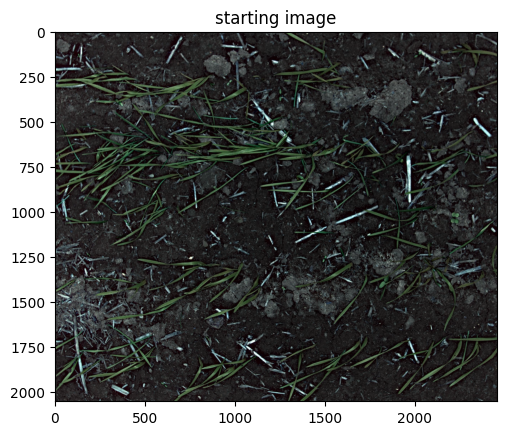

In [45]:
plt.imshow(starting_image)
plt.title(f'starting image')
plt.show()

In [46]:
crop_boxes = []
for box in boxes_big:
    if is_valid_bbox(boxes, box, 0.5):
        crop_boxes.append(box)
        starting_image[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1

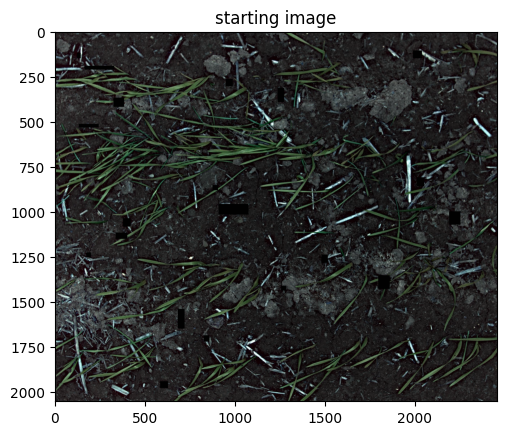

In [47]:
plt.imshow(starting_image)
plt.title(f'starting image')
plt.show()